In [35]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
import os
import torch.nn as nn
import torch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
from tqdm import tqdm
from torch.optim import Adam
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [2]:
def smape( data , pred ):
 return 1/ len (data) * np.sum (2 * np.abs (pred-data) / (np.abs (data) + np.abs (pred)))

In [3]:
data = pd.read_csv('powerconsumption.csv')

In [4]:
data.set_index('Datetime', inplace=True)

In [5]:
data.index = pd.to_datetime(data.index)

In [5]:
data

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259


In [6]:
data.describe()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


In [7]:
missing_values = data.isnull().sum()
missing_values = pd.DataFrame(missing_values[missing_values>0])
missing_values

,0


Пропусков нет, храни боже этот датасет.(Почти в рифму)

In [7]:
df = data.copy()

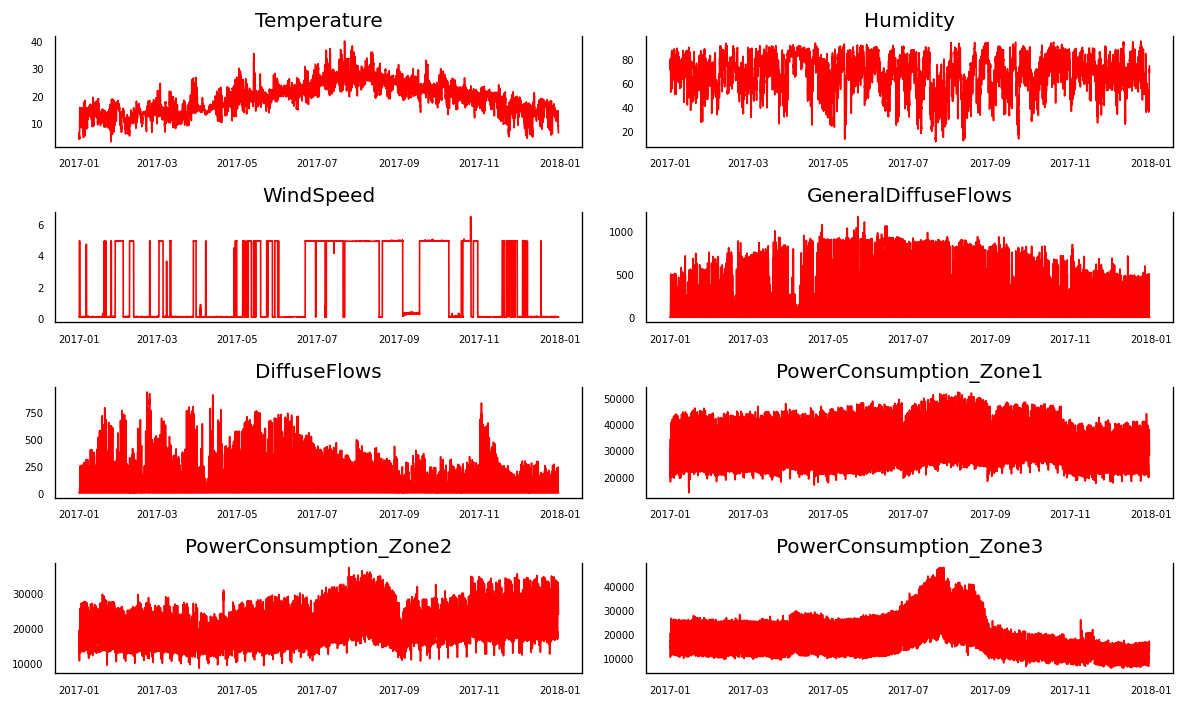

In [8]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [19]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = df
coint_johansen(johan_test_temp,-1,1).eig

array([5.36854899e-02, 3.64325525e-02, 3.18059765e-02, 1.07673158e-02,
       6.13204498e-03, 2.97668183e-03, 1.89401605e-03, 1.78586333e-05])

In [25]:
# Разница между соседними значениями в столбце timestamp
time_diff = df.index.diff()

# Проверка, есть ли значения, отличающиеся от 10 минут
result = (time_diff == pd.Timedelta(minutes=10)).all()
result

False

Ещё и проблям с временными метками нет. Вообще красота.

In [12]:
from statsmodels.tsa.vector_ar.var_model import VAR


model = VAR(df)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\k_dys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  43.157586001342395
BIC :  43.16976610746468
FPE :  5.53479388772159e+18
HQIC:  43.161393013250915 

Lag Order = 2
AIC :  41.3947216433488
BIC :  41.417728899909775
FPE :  9.495092276350158e+17
HQIC:  41.40191279392834 

Lag Order = 3
AIC :  41.35884103798441
BIC :  41.392675811537316
FPE :  9.1604422461173e+17
HQIC:  41.369416447793085 

Lag Order = 4
AIC :  41.32737229601944
BIC :  41.37203495313718
FPE :  8.876663162995064e+17
HQIC:  41.34133208562201 

Lag Order = 5
AIC :  41.30716133606702
BIC :  41.36265224334215
FPE :  8.699058119918368e+17
HQIC:  41.32450562603486 

Lag Order = 6
AIC :  41.28381655658653
BIC :  41.35013608063125
FPE :  8.498332604238547e+17
HQIC:  41.30454546749767 

Lag Order = 7
AIC :  41.270595211479524
BIC :  41.34774371892569
FPE :  8.38671274547063e+17
HQIC:  41.294708863918615 

Lag Order = 8
AIC :  41.25466473117159
BIC :  41.342642588670714
FPE :  8.254166972826387e+17
HQIC:  41.282163245729926 

Lag Order = 9
AIC :  41.243007515586

In [8]:
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [25]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(data, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 8/8 [00:47<00:00,  5.98s/it]


,Temperature_x,Humidity_x,WindSpeed_x,GeneralDiffuseFlows_x,DiffuseFlows_x,PowerConsumption_Zone1_x,PowerConsumption_Zone2_x,PowerConsumption_Zone3_x
Temperature_y,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
Humidity_y,0.0,1.0000,0.0402,0.0000,0.0000,0.0000,0.0,0.0
WindSpeed_y,0.0,0.2546,1.0000,0.5911,0.0015,0.0001,0.0,0.0
GeneralDiffuseFlows_y,0.0,0.0000,0.0021,1.0000,0.0000,0.0000,0.0,0.0
DiffuseFlows_y,0.0,0.0000,0.1024,0.0000,0.9404,0.0000,0.0,0.0
PowerConsumption_Zone1_y,0.0,0.0000,0.0000,0.0000,0.0000,1.0000,0.0,0.0
PowerConsumption_Zone2_y,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,0.0
PowerConsumption_Zone3_y,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,1.0


In [9]:
for col in df.columns:
    if col != 'Date':
        df_test(col, data[col])

Тест Дики-Фуллера ряда Temperature:
Test Statistic                -9.459828e+00
p-value                        4.384186e-16
#Lags Users                    5.800000e+01
Number of Observations Used    5.235700e+04
Critical Value (1%)           -3.430475e+00
Critical Value (5%)           -2.861595e+00
Critical Value (10%)          -2.566799e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Humidity:
Test Statistic                -1.718425e+01
p-value                        6.616076e-30
#Lags Users                    5.800000e+01
Number of Observations Used    5.235700e+04
Critical Value (1%)           -3.430475e+00
Critical Value (5%)           -2.861595e+00
Critical Value (10%)          -2.566799e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда WindSpeed:
Test Statistic                -6.982260e+00
p-value                        8.135108e-10
#Lags Users                    5.700000e+01
Number of Observations Used    5.23

In [40]:
train_data = df.drop(['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3'], axis = 1)

In [133]:
class AnekdoteRNN(nn.Module):
    def __init__(self, num_tokens: int, hidden_size: int=128):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=5,
            hidden_size=hidden_size,
            num_layers=4,
            batch_first=True
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, num_tokens)
        )

    def forward(self, x):
        x, _ = self.rnn(x)
        x  = self.output(x)

        return x

In [135]:
model = AnekdoteRNN(num_tokens = 1)

In [118]:
train_data

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Datetime,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074


In [102]:
a = np.array(train_data)

In [99]:
tar_train = np.array(df['PowerConsumption_Zone1'][1:int(len(a)*0.8)+1])
tar_test = np.array(df['PowerConsumption_Zone1'][int(len(a)*0.8)+1:])

In [103]:
train = a[1:int(len(a)*0.8)+1]
test = a[int(len(a)*0.8)+1:]

In [101]:
tar_train

array([29814.68354, 29128.10127, 28228.86076, ..., 25371.72867,
       25554.48578, 25573.39168])

In [13]:
from torch.utils.data import DataLoader, TensorDataset

In [131]:
df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259


In [10]:
import numpy as np

feature_cols = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']
target_col = 'PowerConsumption_Zone1'

X = df[feature_cols].values
Y = df[target_col].values

n_features = X.shape[1]
lookback = 30 ## 5 hours lookback to make prediction

X_organized, Y_organized = [], []
for i in range(0, X.shape[0]-lookback, 1):
    X_organized.append(X[i:i+lookback])
    Y_organized.append(Y[i+lookback])

X_organized, Y_organized = np.array(X_organized), np.array(Y_organized)
X_organized, Y_organized = torch.tensor(X_organized, dtype=torch.float32), torch.tensor(Y_organized, dtype=torch.float32)
X_train, Y_train, X_test, Y_test = X_organized[:45000], Y_organized[:45000], X_organized[45000:], Y_organized[45000:]

X_organized.shape, Y_organized.shape, X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([52386, 30, 5]),
 torch.Size([52386]),
 torch.Size([45000, 30, 5]),
 torch.Size([45000]),
 torch.Size([7386, 30, 5]),
 torch.Size([7386]))

In [11]:
mean, std = Y_train.mean(), Y_train.std()

print("Mean : {:.2f}, Standard Deviation : {:.2f}".format(mean, std))
Y_train_scaled, Y_test_scaled = (Y_train - mean)/std , (Y_test-mean)/std

Y_train_scaled.min(), Y_train_scaled.max(), Y_test_scaled.min(), Y_test_scaled.max()

Mean : 32892.72, Standard Deviation : 7141.31


(tensor(-2.6602), tensor(2.7042), tensor(-2.1578), tensor(1.5515))

In [14]:
train_dataset = TensorDataset(X_train, Y_train_scaled)
test_dataset  = TensorDataset(X_test,  Y_test_scaled)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=32)
test_loader  = DataLoader(test_dataset,  shuffle=False, batch_size=32)

In [155]:
from torch.nn import functional as F

hidden_dim = 128
n_layers=2

class LSTMRegressor(nn.Module):
    def __init__(self):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, X_batch):
        X_batch.to('cuda')
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(X_batch, (hidden, carry))
        return self.linear(output[:,-1])

In [156]:
lstm_regressor = LSTMRegressor()

lstm_regressor

LSTMRegressor(
  (lstm): LSTM(5, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [157]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import gc

def CalcValLoss(model, loss_fn, val_loader):
    with torch.no_grad():
        losses = []
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds.ravel(), Y)
            losses.append(loss.item())
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds.ravel(), Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLoss(model, loss_fn, val_loader)

In [185]:
from torch.optim import Adam

epochs = 10
learning_rate = 1e-2

loss_fn = nn.MSELoss()
lstm_regressor = LSTMRegressor()
optimizer = Adam(lstm_regressor.parameters(), lr=learning_rate)

TrainModel(lstm_regressor, loss_fn, optimizer, train_loader, test_loader, epochs)

  9%|▉         | 129/1407 [00:02<00:22, 58.06it/s]


KeyboardInterrupt: 

In [160]:
test_preds = lstm_regressor(X_test) ## Make Predictions on test dataset
test_preds  = (test_preds*std) + mean

test_preds[:5]

tensor([[31157.4609],
        [31650.8105],
        [31330.1543],
        [31710.0156],
        [31716.6719]], grad_fn=<SliceBackward0>)

In [169]:
data_df_final = df[45000:].copy()

data_df_final["Zone 1 Power Consumption Prediction"] = [None]*lookback + test_preds.detach().numpy().squeeze().tolist()

data_df_final.tail()


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Zone 1 Power Consumption Prediction
Datetime,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,25123.519531
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,24171.656250
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23219.503906
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,22902.964844
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,22835.228516


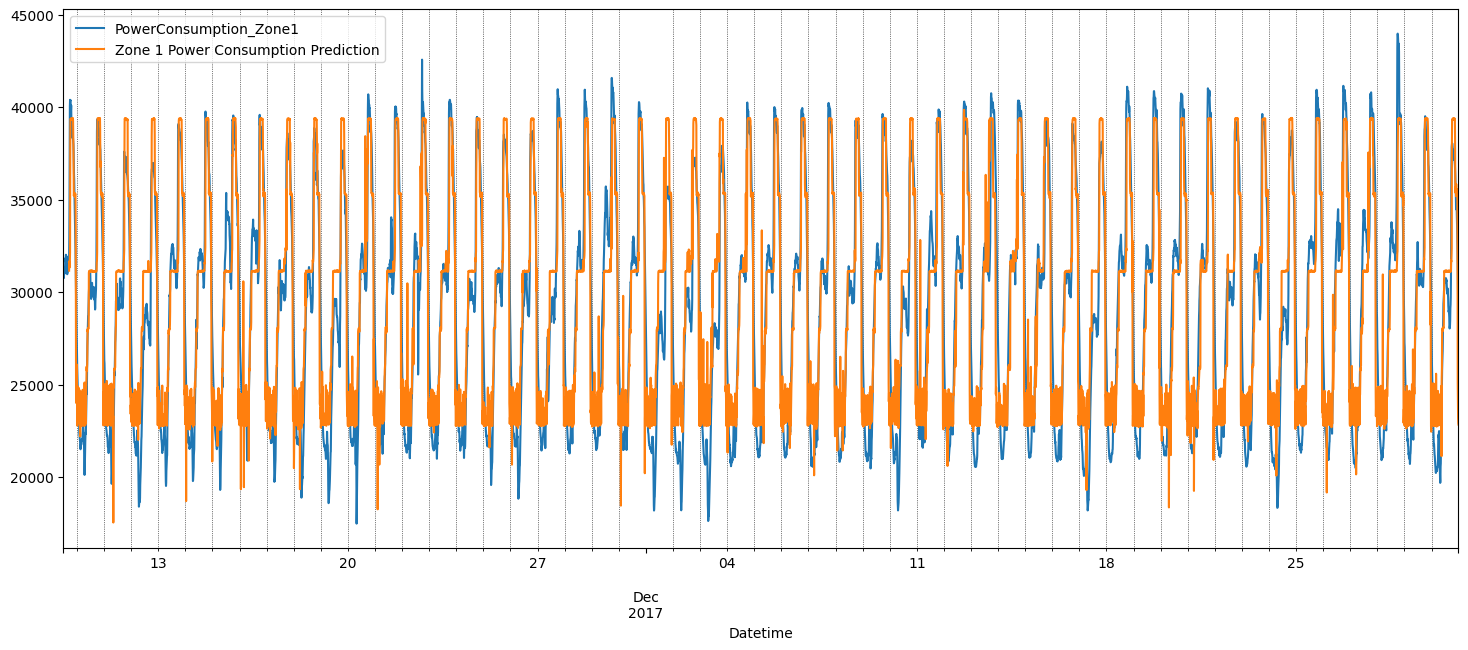

In [163]:
data_df_final.plot(y=["PowerConsumption_Zone1", "Zone 1 Power Consumption Prediction"],figsize=(18,7))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [177]:
print("RMSE:", np.sqrt(mean_squared_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:])))
print("MAPE:", mean_absolute_percentage_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("MAE:", mean_absolute_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("R2: ", r2_score(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("SMAPE: ", smape(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))

RMSE: 2245.056039988919
MAPE: 6.293188955518376
MAE: 1734.1922981769
R2:  0.8638565698091515
SMAPE:  0.06243229092879338


In [26]:
from torch.nn import functional as F

hidden_dim = 128
n_layers=2

class GRURegressor(nn.Module):
    def __init__(self):
        super(GRURegressor, self).__init__()
        self.gru = nn.GRU(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, X_batch):
        hidden = torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden) = self.gru(X_batch, (hidden.detach()))
        return self.linear(output[:,-1])

In [27]:
gru_regressor = GRURegressor()

gru_regressor

GRURegressor(
  (gru): GRU(5, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [28]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import gc

def CalcValLoss(model, loss_fn, val_loader):
    with torch.no_grad():
        losses = []
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds.ravel(), Y)
            losses.append(loss.item())
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds.ravel(), Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLoss(model, loss_fn, val_loader)

In [29]:
from torch.optim import Adam

epochs = 10
learning_rate = 1e-2

loss_fn = nn.MSELoss()
gru_regressor = GRURegressor()
optimizer = Adam(gru_regressor.parameters(), lr=learning_rate)

TrainModel(gru_regressor, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 1407/1407 [00:40<00:00, 34.35it/s]


Train Loss : 0.294
Valid Loss : 0.134


100%|██████████| 1407/1407 [00:43<00:00, 32.29it/s]


Train Loss : 0.273
Valid Loss : 0.158


100%|██████████| 1407/1407 [00:50<00:00, 27.60it/s]


Train Loss : 0.295
Valid Loss : 0.155


100%|██████████| 1407/1407 [00:47<00:00, 29.82it/s]


Train Loss : 0.302
Valid Loss : 0.160


100%|██████████| 1407/1407 [00:47<00:00, 29.58it/s]


Train Loss : 0.319
Valid Loss : 0.163


100%|██████████| 1407/1407 [00:47<00:00, 29.48it/s]


Train Loss : 0.298
Valid Loss : 0.165


100%|██████████| 1407/1407 [00:48<00:00, 29.04it/s]


Train Loss : 0.296
Valid Loss : 0.147


100%|██████████| 1407/1407 [00:47<00:00, 29.77it/s]


Train Loss : 0.311
Valid Loss : 0.162


100%|██████████| 1407/1407 [00:47<00:00, 29.56it/s]


Train Loss : 0.302
Valid Loss : 0.148


100%|██████████| 1407/1407 [00:48<00:00, 29.27it/s]


Train Loss : 0.285
Valid Loss : 0.151


In [31]:
test_preds = gru_regressor(X_test) ## Make Predictions on test dataset
test_preds  = (test_preds*std) + mean

test_preds[:5]

tensor([[31163.2734],
        [34315.7500],
        [34677.2969],
        [30797.7012],
        [29351.7227]], grad_fn=<SliceBackward0>)

In [32]:
data_df_final = df[45000:].copy()

data_df_final["Zone 1 Power Consumption Prediction"] = [None]*lookback + test_preds.detach().numpy().squeeze().tolist()

data_df_final.tail()


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Zone 1 Power Consumption Prediction
Datetime,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,32841.484375
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,37762.171875
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,22125.179688
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,22815.248047
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,23479.037109


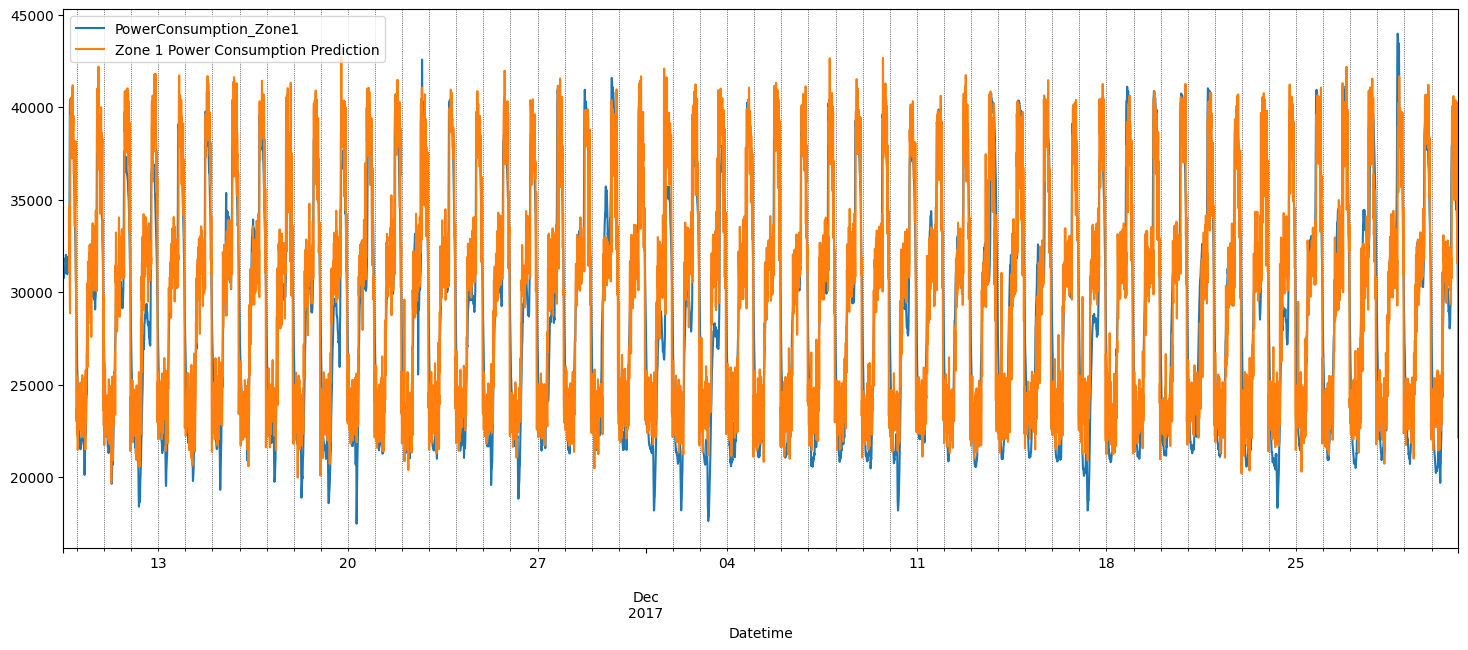

In [33]:
data_df_final.plot(y=["PowerConsumption_Zone1", "Zone 1 Power Consumption Prediction"],figsize=(18,7))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [36]:
print("RMSE:", np.sqrt(mean_squared_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:])))
print("MAPE:", mean_absolute_percentage_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("MAE:", mean_absolute_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("R2: ", r2_score(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("SMAPE: ", smape(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))

RMSE: 2781.4533242810153
MAPE: 0.07739166984298917
MAE: 2143.0486990724007
R2:  0.7910290730127095
SMAPE:  0.0760789690081942


In [44]:
from torch.nn import functional as F

hidden_dim = 196
n_layers=2

class RNNRegressor(nn.Module):
    def __init__(self):
        super(RNNRegressor, self).__init__()
        self.rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, X_batch):
        hidden = torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden) = self.rnn(X_batch, (hidden.detach()))
        return self.linear(output[:,-1])

In [45]:
rnn_regressor = GRURegressor()

rnn_regressor

GRURegressor(
  (gru): GRU(5, 196, num_layers=2, batch_first=True)
  (linear): Linear(in_features=196, out_features=1, bias=True)
)

In [39]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import gc

def CalcValLoss(model, loss_fn, val_loader):
    with torch.no_grad():
        losses = []
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds.ravel(), Y)
            losses.append(loss.item())
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds.ravel(), Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLoss(model, loss_fn, val_loader)

In [48]:
from torch.optim import Adam

epochs = 10
learning_rate = 1e-3

loss_fn = nn.MSELoss()
gru_regressor = GRURegressor()
optimizer = Adam(rnn_regressor.parameters(), lr=learning_rate)

TrainModel(gru_regressor, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 1407/1407 [00:51<00:00, 27.35it/s]


Train Loss : 1.130
Valid Loss : 0.893


100%|██████████| 1407/1407 [00:52<00:00, 26.69it/s]


Train Loss : 1.127
Valid Loss : 0.897


100%|██████████| 1407/1407 [00:53<00:00, 26.21it/s]


Train Loss : 1.129
Valid Loss : 0.897


100%|██████████| 1407/1407 [00:52<00:00, 26.83it/s]


Train Loss : 1.129
Valid Loss : 0.893


100%|██████████| 1407/1407 [00:53<00:00, 26.50it/s]


Train Loss : 1.129
Valid Loss : 0.894


100%|██████████| 1407/1407 [00:52<00:00, 26.72it/s]


Train Loss : 1.128
Valid Loss : 0.896


100%|██████████| 1407/1407 [00:52<00:00, 26.64it/s]


Train Loss : 1.127
Valid Loss : 0.893


100%|██████████| 1407/1407 [00:53<00:00, 26.07it/s]


Train Loss : 1.127
Valid Loss : 0.895


100%|██████████| 1407/1407 [00:52<00:00, 26.99it/s]


Train Loss : 1.130
Valid Loss : 0.897


100%|██████████| 1407/1407 [00:51<00:00, 27.07it/s]


Train Loss : 1.128
Valid Loss : 0.897


In [49]:
test_preds = gru_regressor(X_test) ## Make Predictions on test dataset
test_preds  = (test_preds*std) + mean

test_preds[:5]

tensor([[34045.6250],
        [33903.1875],
        [31627.1934],
        [33264.4961],
        [33019.5820]], grad_fn=<SliceBackward0>)

In [50]:
data_df_final = df[45000:].copy()

data_df_final["Zone 1 Power Consumption Prediction"] = [None]*lookback + test_preds.detach().numpy().squeeze().tolist()

data_df_final.tail()


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Zone 1 Power Consumption Prediction
Datetime,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,32317.343750
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,32233.566406
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,31475.378906
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,32765.958984
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,31115.031250


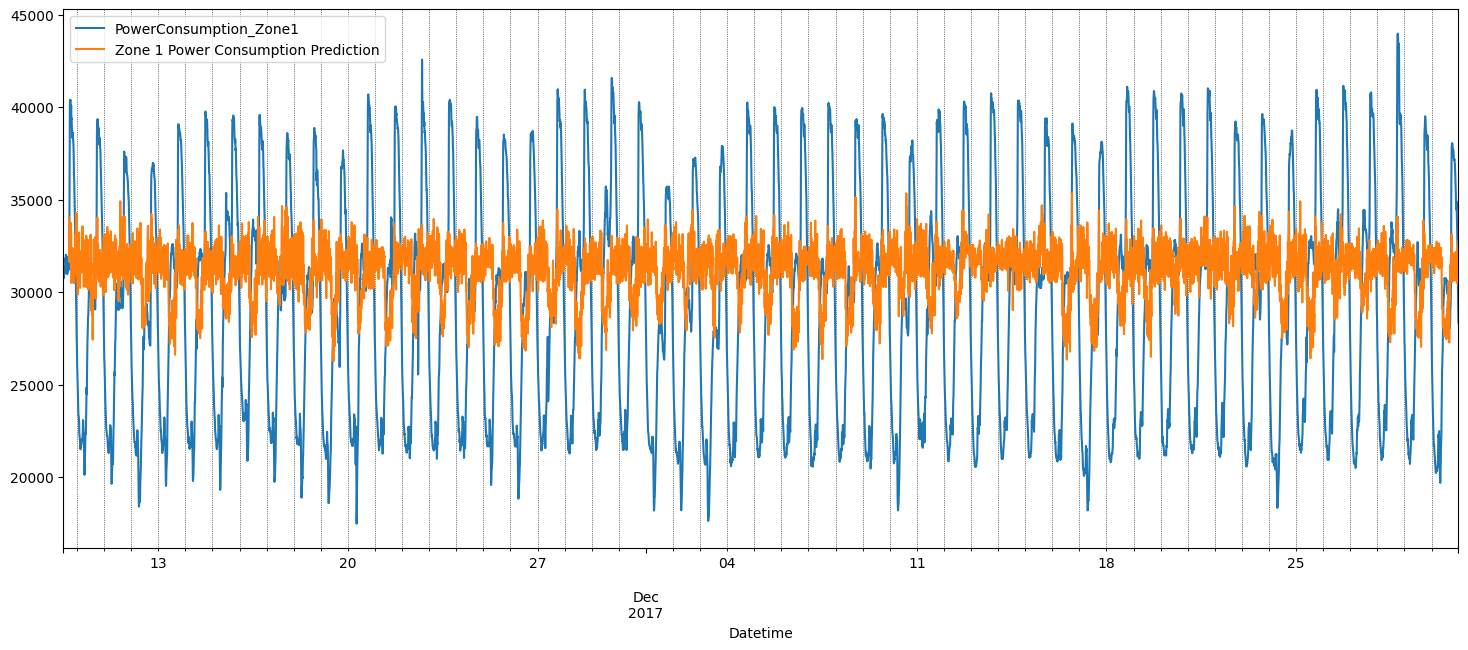

In [51]:
data_df_final.plot(y=["PowerConsumption_Zone1", "Zone 1 Power Consumption Prediction"],figsize=(18,7))
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [52]:
print("RMSE:", np.sqrt(mean_squared_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:])))
print("MAPE:", mean_absolute_percentage_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("MAE:", mean_absolute_error(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("R2: ", r2_score(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))
print("SMAPE: ", smape(data_df_final['PowerConsumption_Zone1'][30:], data_df_final['Zone 1 Power Consumption Prediction'][30:]))

RMSE: 6766.370944957226
MAPE: 0.22200716000346962
MAE: 5709.30003352779
R2:  -0.23667027552462105
SMAPE:  0.1965351676620825


In [21]:
import gluonts.torch
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.dataset.split import split
from gluonts.dataset.pandas import PandasDataset

In [13]:
pdts_data = PandasDataset(train_data, target='PowerConsumption_Zone1')
train,test = split(pdts_data, offset=-2500)

In [14]:
test = test.generate_instances(prediction_length = 2500, windows=1)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
device

'cuda'

In [33]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data
 
model = DeepAREstimator(freq = '10min', prediction_length=2500, trainer_kwargs={'max_epochs':50})

EPOCHS = 1

In [34]:
device = 'cuda'
model.to(device)

AttributeError: 'DeepAREstimator' object has no attribute 'to'

In [36]:
predictor = model.train(train,  device = device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
C:\Users\k_dys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | In sizes                                                           | Out sizes     
----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.6 K | [[1, 1], [1, 1], [1, 3508, 6], [1, 3508], [1, 3508], [1, 2500, 6]] | [1, 100, 2500]
----------------------------------------------------------------------------------------------------------------------------
27.6 K    Trainable params
0         Non-trainable params
27.6 K    Total params
0.111     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 10.91188 (best 10.91188), saving model to 'd:\\GitRepso\\Timeseries-Tasks\\Final dataset\\lightning_logs\\version_3\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.30437 (best 9.30437), saving model to 'd:\\GitRepso\\Timeseries-Tasks\\Final dataset\\lightning_logs\\version_3\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.88190 (best 8.88190), saving model to 'd:\\GitRepso\\Timeseries-Tasks\\Final dataset\\lightning_logs\\version_3\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 8.62599 (best 8.62599), saving model to 'd:\\GitRepso\\Timeseries-Tasks\\Final dataset\\lightning_logs\\version_3\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.45630 (best 8.45630), saving model to 'd:\\GitRepso\\Timeseries-Tas

In [37]:
forecast = list(predictor.predict(test.input))

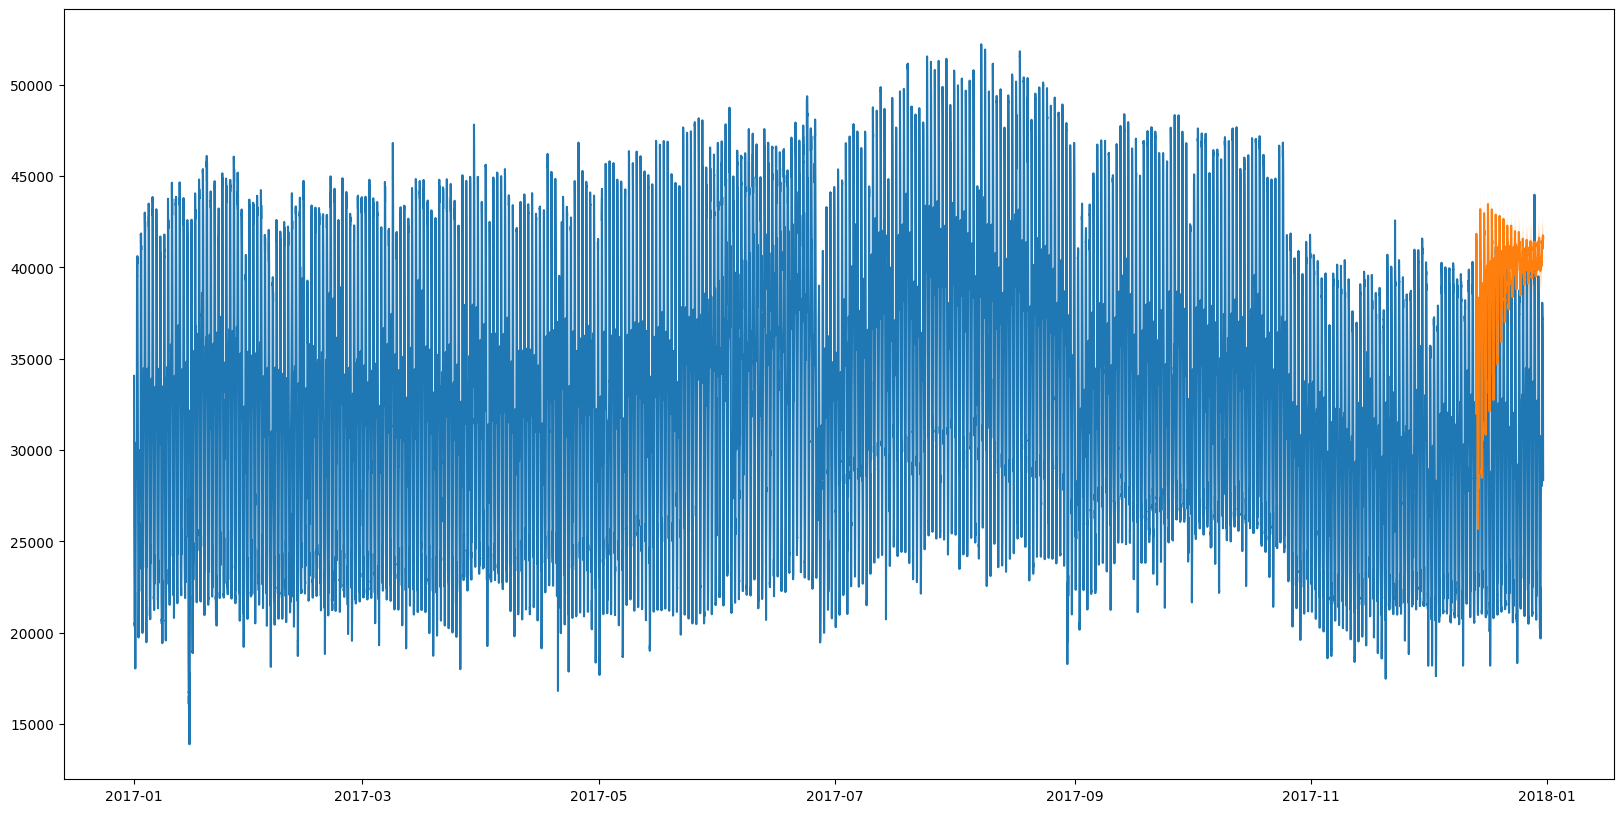

In [38]:
plt.figure(figsize=(20,10))
plt.plot(data['PowerConsumption_Zone1'])
for fore in forecast:
    fore.plot()

In [39]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [40]:
def smape( data , pred ):
 return 1/ len (data) * np.sum (2 * np.abs (pred-data) / (np.abs (data) + np.abs (pred)))

In [41]:
offset = 2500
predictions = forecast[-1].samples[-1]

In [42]:
print("RMSE:", np.sqrt(mean_squared_error(df['PowerConsumption_Zone1'][len(df['PowerConsumption_Zone1'])-offset:], predictions)))
print("MAPE:", mean_absolute_percentage_error(df['PowerConsumption_Zone1'][len(df['PowerConsumption_Zone1'])-offset:], predictions))
print("MAE:", mean_absolute_error(df['PowerConsumption_Zone1'][len(df['PowerConsumption_Zone1'])-offset:], predictions))
print("R2: ", r2_score(df['PowerConsumption_Zone1'][len(df['PowerConsumption_Zone1'])-offset:], predictions))
print("SMAPE: ", smape(df['PowerConsumption_Zone1'][len(df['PowerConsumption_Zone1'])-offset:], predictions))

RMSE: 11105.888450943114
MAPE: 0.38293334443020977
MAE: 9756.9500225075
R2:  -2.1359619452673186
SMAPE:  0.30148656964050025


In [10]:
train = df[:int(0.8*(len(data)))]
test = df[int(0.8*(len(data))):]

In [27]:
orders = [2,6,12,20,24,30,40,48,50,96,168,252,336]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]

for i,j in enumerate(zip(*results)):
    print('Lag Order =', orders[i])
    print('AIC : ', j[0], "*" if i == best_pos[0] else "")
    print('BIC : ', j[1], "*" if i == best_pos[1] else "")
    print('FPE : ', j[2], "*" if i == best_pos[2] else "")
    print('HQIC: ', j[3], "*" if i == best_pos[3] else "", '\n')

Lag Order = 2
AIC :  41.3947216433488 
BIC :  41.417728899909775 
FPE :  9.495092276350158e+17 
HQIC:  41.40191279392834  

Lag Order = 6
AIC :  41.28381655658653 
BIC :  41.35013608063125 
FPE :  8.498332604238547e+17 
HQIC:  41.30454546749767  

Lag Order = 12
AIC :  41.216986429272396 
BIC :  41.34828535389151 *
FPE :  7.94895029987845e+17 
HQIC:  41.25802559835329  

Lag Order = 20
AIC :  41.18433787783401 
BIC :  41.40229654194186 
FPE :  7.693620289993542e+17 
HQIC:  41.252464146359415  

Lag Order = 24
AIC :  41.17947997384547 
BIC :  41.4407773128394 
FPE :  7.656336912814802e+17 
HQIC:  41.26115268814263  

Lag Order = 30
AIC :  41.173703157887935 
BIC :  41.50001951917964 
FPE :  7.61223709347566e+17 
HQIC:  41.2756991621002  

Lag Order = 40
AIC :  41.16700490266655 
BIC :  41.60171567153608 
FPE :  7.561424130983679e+17 
HQIC:  41.302882716968035  

Lag Order = 48
AIC :  41.16732749576939 
BIC :  41.68878023541884 
FPE :  7.56387053112179e+17 
HQIC:  41.33031945617965  

La

In [26]:
x = model.select_order(maxlags=200)
x.summary()

KeyboardInterrupt: 

In [74]:
train[0]

array([6.55900000e+00, 7.38000000e+01, 8.30000000e-02, 5.10000000e-02,
       1.19000000e-01, 3.40556962e+04, 1.61288754e+04, 2.02409639e+04])

In [75]:
model = VAR(train)

In [76]:
model_fitted = model.fit(168)
model_fitted.summary()

C:\Users\k_dys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\vector_ar\var_model.py:1502: RuntimeWarning: invalid value encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Jan, 2024
Time:                     17:02:20
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    42.4894
Nobs:                     41764.0    HQIC:                   40.9666
Log likelihood:      -1.30411e+06    FPE:                3.06382e+17
AIC:                      40.2634    Det(Omega_mle):     2.37758e+17
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.058902         0.017610           -3.345           0.001
L1.y1           1.294245         0.005622          230.220           0.000
L1.y2          -0.025406         0.000921          -27.596           0.000
L1.y3       

In [50]:
lag_order = model_fitted.k_ar
print(lag_order) 

168


In [51]:
forecast_input = df.values[-lag_order:]
forecast_input

array([[1.35300000e+01, 5.03000000e+01, 7.60000000e-02, ...,
        3.76821293e+04, 3.26640074e+04, 1.65781513e+04],
       [1.36200000e+01, 4.99700000e+01, 7.90000000e-02, ...,
        3.81809886e+04, 3.30285364e+04, 1.66876351e+04],
       [1.36500000e+01, 4.99300000e+01, 7.90000000e-02, ...,
        3.84730038e+04, 3.29180730e+04, 1.66761104e+04],
       ...,
       [6.90000000e+00, 7.28000000e+01, 8.60000000e-02, ...,
        2.95908745e+04, 2.52776925e+04, 1.38064826e+04],
       [6.75800000e+00, 7.30000000e+01, 8.00000000e-02, ...,
        2.89581749e+04, 2.46922369e+04, 1.35126050e+04],
       [6.58000000e+00, 7.41000000e+01, 8.10000000e-02, ...,
        2.83498099e+04, 2.40552317e+04, 1.33454982e+04]])

In [31]:
# Forecast
nobs = 100 # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Temperature_2d,Humidity_2d,WindSpeed_2d,GeneralDiffuseFlows_2d,DiffuseFlows_2d,PowerConsumption_Zone1_2d,PowerConsumption_Zone2_2d,PowerConsumption_Zone3_2d
Datetime,,,,,,,,
2017-12-30 07:20:00,6.515029,74.477365,0.063573,5.248467,-0.421980,27661.503781,23480.632891,13106.270790
2017-12-30 07:30:00,6.531653,74.487379,0.047351,11.000865,5.906746,26934.722168,22835.704824,12740.722486
2017-12-30 07:40:00,6.532577,74.504249,0.022911,10.324830,2.645217,26242.153593,22248.096510,12382.347987
2017-12-30 07:50:00,6.554532,74.464617,0.013877,11.888348,4.979324,25624.311173,21719.094249,12094.017429
2017-12-30 08:00:00,6.582642,74.296221,0.035026,10.680975,3.965733,25064.507546,21241.966765,11825.837105
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,13.071902,54.586611,0.423684,272.146865,110.829563,28161.472718,24357.271419,10408.845730
2017-12-30 23:20:00,13.031884,54.781160,0.418620,249.359952,136.285187,28066.299978,24288.616521,10352.737425
2017-12-30 23:30:00,12.950529,55.144963,0.391507,230.123383,163.167602,27949.656892,24206.867827,10282.608866


In [45]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)])
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)])
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)])
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)])
    return X_train, Y_train

In [77]:
X_test, Y_test = create_test_dataset(test, 168)
X_train, Y_train = create_train_dataset(train, 168)

In [78]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [79]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

In [80]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

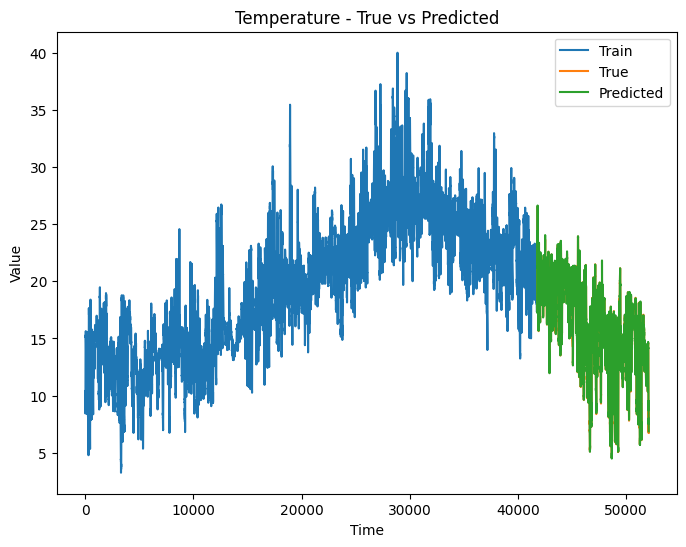

Метрики Temperature
MSE: 0.03885688612018102
RMSE: 0.1971215009078944
MAE: 0.1222768437394322
SMAPE: 0.002
R2: 0.9976188841260328 



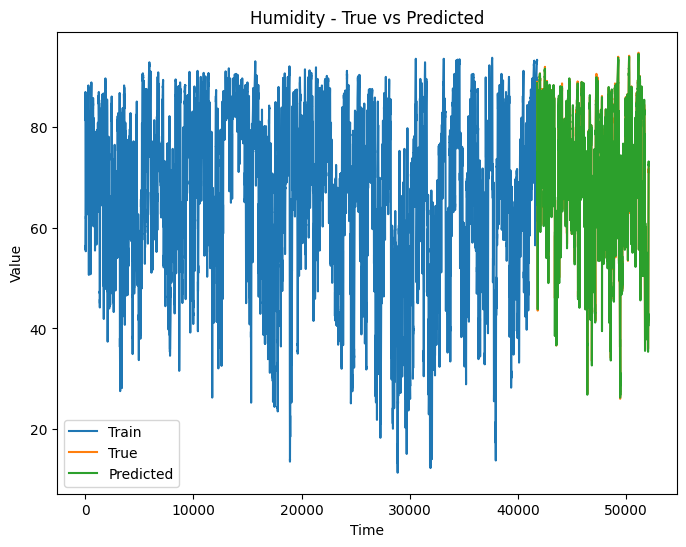

Метрики Humidity
MSE: 1.197804811187302
RMSE: 1.0944426943368493
MAE: 0.6512843208855031
SMAPE: 0.003
R2: 0.9928848489718102 



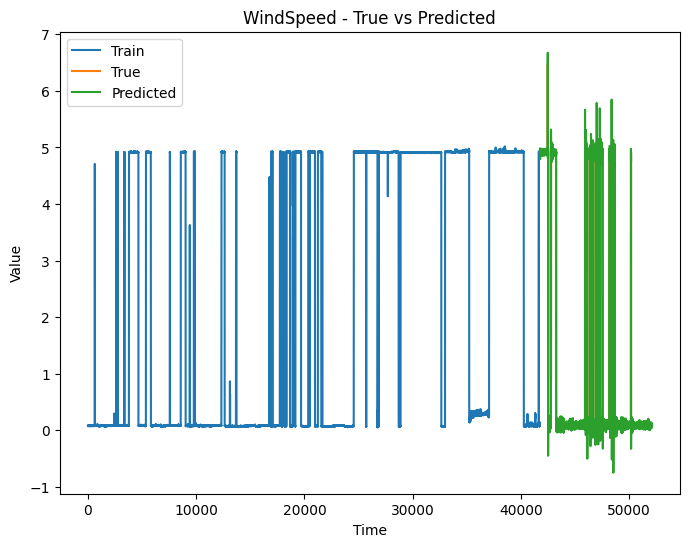

Метрики WindSpeed
MSE: 0.052261618414679405
RMSE: 0.2286080016418485
MAE: 0.0519794337287166
SMAPE: 0.073
R2: 0.9876297383311115 



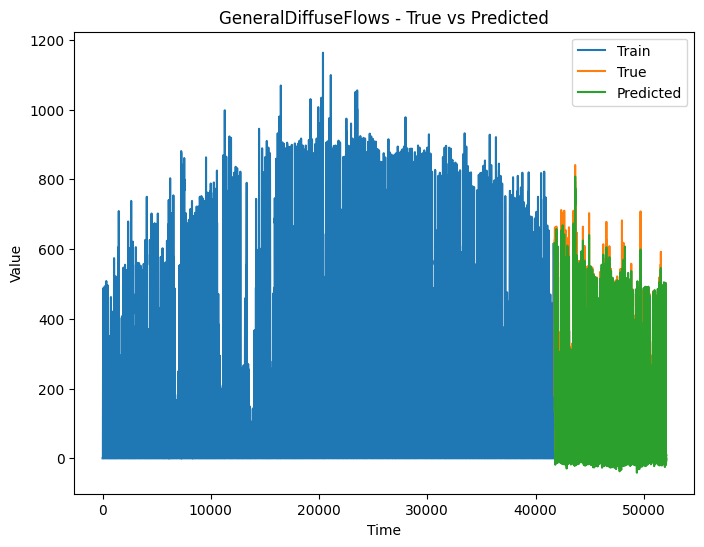

Метрики GeneralDiffuseFlows
MSE: 1327.4813832502352
RMSE: 36.434617923758104
MAE: 16.90614368595656
SMAPE: 0.301
R2: 0.9555262167964159 



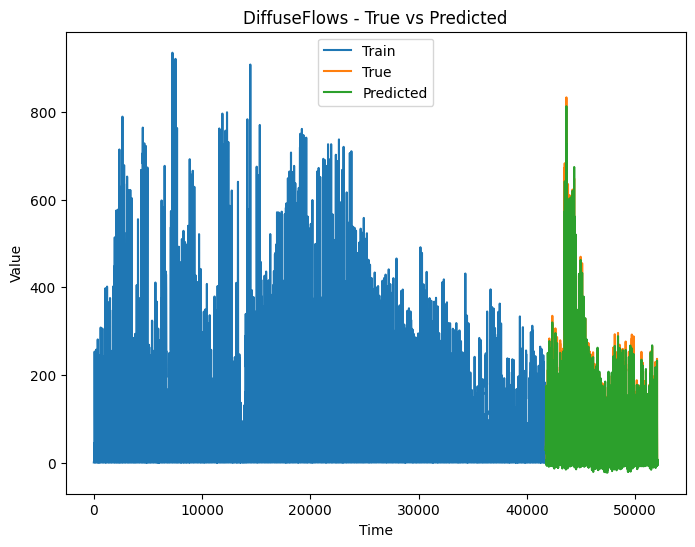

Метрики DiffuseFlows
MSE: 567.8230800977534
RMSE: 23.829038589455376
MAE: 10.255853240735062
SMAPE: 0.288
R2: 0.9342779926091369 



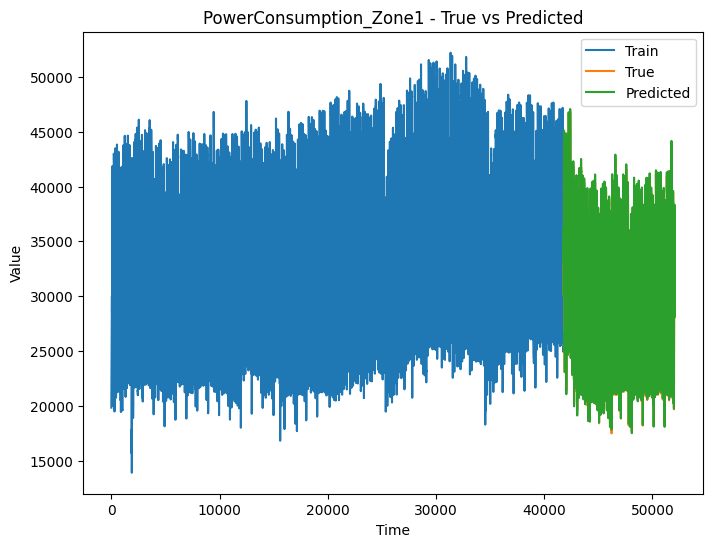

Метрики PowerConsumption_Zone1
MSE: 91133.1004476922
RMSE: 301.88259381370796
MAE: 214.11179929244946
SMAPE: 0.002
R2: 0.9975888603887851 



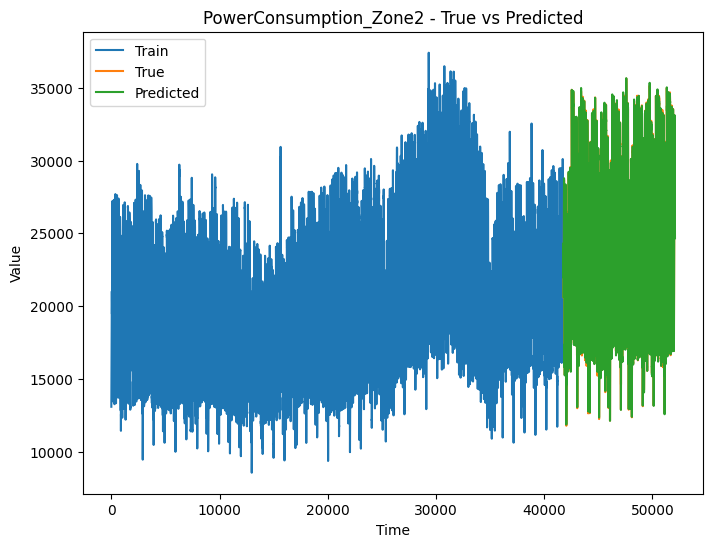

Метрики PowerConsumption_Zone2
MSE: 68012.24880385034
RMSE: 260.79158115984177
MAE: 167.62862621022634
SMAPE: 0.002
R2: 0.9977502823997272 



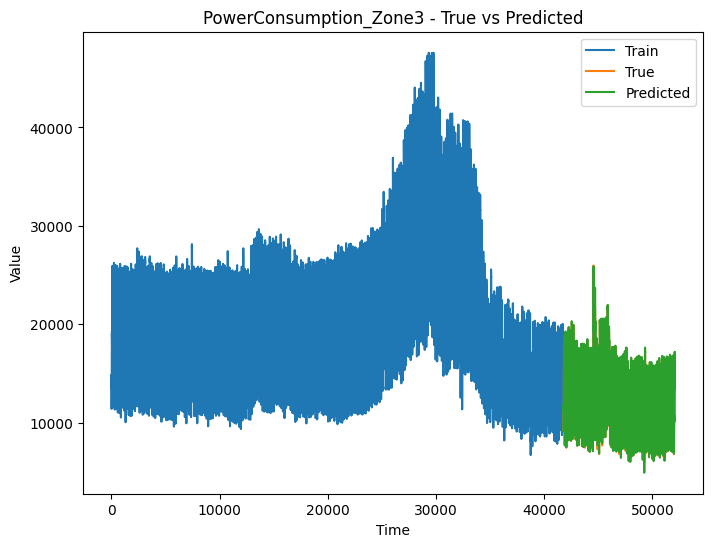

Метрики PowerConsumption_Zone3
MSE: 50089.06292492038
RMSE: 223.80585989852986
MAE: 129.8609913766548
SMAPE: 0.003
R2: 0.9954077974859381 



In [81]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)